# K-Means Clustering on the data set

## Libraries

In [694]:
import pandas as pd
import numpy as np
import math
%matplotlib inline
from matplotlib import pyplot as plt
import random
#random.seed(1)

## Importing the data set
Our dataset contains images of the **HAM10000** dataset, a large collection of multi-source dermatoscopic images of common pigmented skin lesions.

In [695]:
# IMPORTANT: Filepath depends on OS!
filepath = r'data/hmnist_28_28_L.csv'
df = pd.read_csv(filepath)
print(df) # Shape (#images, h*w+1) (here: (10015, 785))

       pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
0            169        171        170        177        181        182   
1             19         57        105        140        149        148   
2            155        163        161        167        167        172   
3             25         71        116        139        136        153   
4            129        162        181        196        205        208   
...          ...        ...        ...        ...        ...        ...   
10010        172        171        173        175        164        187   
10011          2         34        108        116        114        119   
10012        122        154        162        170        179        197   
10013        137        143        141        139        147        152   
10014        149        157        157        152        151        152   

       pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
0            181   

## Function to display an image

In [696]:
def disp_img(data_vec, colorbar=False):
    # Handle the cases of whether the label for an image is provided or not
    if math.sqrt(np.size(data_vec)) != int(math.sqrt(np.size(data_vec))):
        img_label = data_vec[-1]
        img_vec = data_vec[0:-1]
    else:
        img_vec = data_vec

    size = np.size(img_vec)
    dimension = int(math.sqrt(size))

    img_mat = np.reshape(np.array(img_vec), (dimension, dimension))

    plt.imshow(img_mat)
    if colorbar:
        plt.colorbar()
    plt.show()

## Count occurences of labels

Count the number of data images corresponding to each label.

In [697]:
# Each tuple will contain a label and the number of images with the same label
# [(label, #occurences), ..]
label = df['label']
uniq_label, counts_label = np.unique(label, return_counts=True)
occurences = list(zip(uniq_label, counts_label))
print(occurences)

num_cath = len(uniq_label)

[(0, 327), (1, 514), (2, 1099), (3, 115), (4, 6705), (5, 142), (6, 1113)]


# Partition the images into the different classes
Create a list of nested lists. Each nested list represents a label and contains the indices of all data images with the same label. E.g. img_index_group[2] contains all images for label 2.

In [698]:
# List of 7 nested lists (for each diagnostical categorie)
# The ith nested list contains the indices of all images, which correspond to label i
# E.g. img_index_group[2] contains all images for label 2
img_index_group = []

for i in range(num_cath):
    img_index_group.append([])
    for j in range(df.shape[0]):
        if df['label'][j] == i:
            img_index_group[i].append(j)

print(img_index_group)

# For debugging purposes
# print(list((i, len(img_index_group[i])) for i in range(len(img_index_group))))

[[9687, 9688, 9689, 9690, 9691, 9692, 9693, 9694, 9695, 9696, 9697, 9698, 9699, 9700, 9701, 9702, 9703, 9704, 9705, 9706, 9707, 9708, 9709, 9710, 9711, 9712, 9713, 9714, 9715, 9716, 9717, 9718, 9719, 9720, 9721, 9722, 9723, 9724, 9725, 9726, 9727, 9728, 9729, 9730, 9731, 9732, 9733, 9734, 9735, 9736, 9737, 9738, 9739, 9740, 9741, 9742, 9743, 9744, 9745, 9746, 9747, 9748, 9749, 9750, 9751, 9752, 9753, 9754, 9755, 9756, 9757, 9758, 9759, 9760, 9761, 9762, 9763, 9764, 9765, 9766, 9767, 9768, 9769, 9770, 9771, 9772, 9773, 9774, 9775, 9776, 9777, 9778, 9779, 9780, 9781, 9782, 9783, 9784, 9785, 9786, 9787, 9788, 9789, 9790, 9791, 9792, 9793, 9794, 9795, 9796, 9797, 9798, 9799, 9800, 9801, 9802, 9803, 9804, 9805, 9806, 9807, 9808, 9809, 9810, 9811, 9812, 9813, 9814, 9815, 9816, 9817, 9818, 9819, 9820, 9821, 9822, 9823, 9824, 9825, 9826, 9827, 9828, 9829, 9830, 9831, 9832, 9833, 9834, 9835, 9836, 9837, 9838, 9839, 9840, 9841, 9842, 9843, 9844, 9845, 9846, 9847, 9848, 9849, 9850, 9851, 9852, 98

## Visualizing one Image of each Cathegory

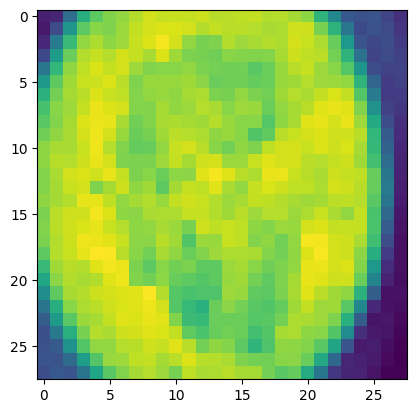

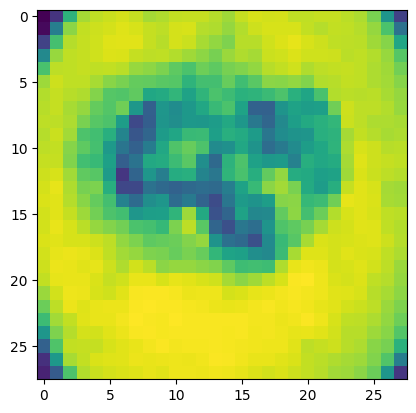

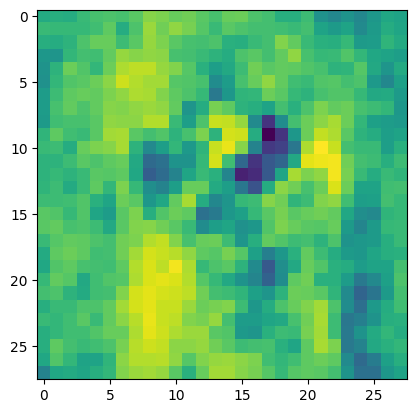

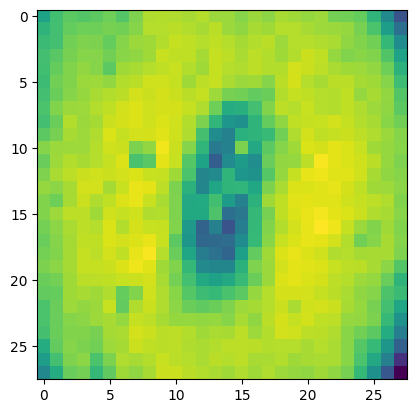

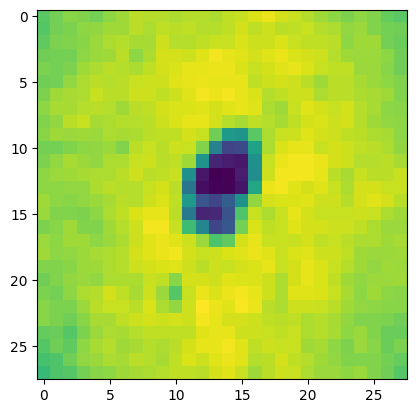

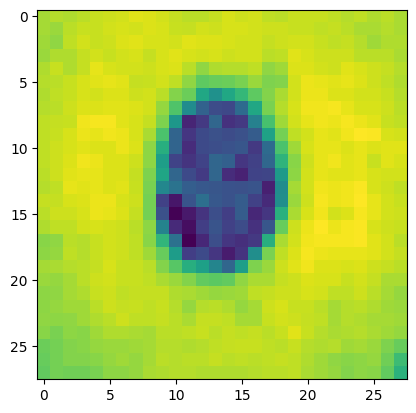

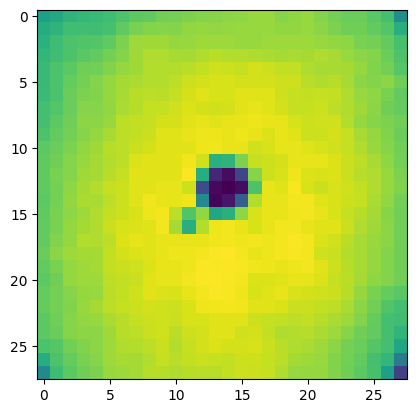

In [699]:
for i in range(len(img_index_group)):
    disp_img(df.iloc[img_index_group[i][0]])

# Splitting into training and testing data

In [700]:
training_split = 0.9                #Percentage of Data used for training
img_index_group_split = []          #Same as img_index_group but every nested list is split into two lists: first is list for training, second is list for testing

for i in range(num_cath):
    random.shuffle(img_index_group[i])
    split_point = round(len(img_index_group[i])*training_split)
    img_index_group_split.append([img_index_group[i][:split_point], img_index_group[i][split_point:]])
    
    #print(i)
    #print(len(img_index_group_split[i][0]))
    #print(len(img_index_group_split[i][1]))

print(img_index_group_split)

[[[9997, 9729, 9737, 9892, 9799, 9777, 9993, 9852, 9797, 9705, 9973, 9702, 9963, 9758, 9976, 10013, 9722, 9776, 9760, 9715, 9978, 9728, 9745, 9975, 9951, 9861, 9896, 9812, 9779, 9735, 10011, 9790, 10001, 9773, 9819, 9753, 10007, 9878, 9863, 9984, 9957, 9904, 9690, 9919, 9811, 9871, 9821, 9991, 9720, 9858, 9798, 9699, 9971, 9872, 9885, 9732, 9950, 9696, 9809, 9884, 9888, 9744, 9693, 9731, 9765, 9887, 9895, 9972, 9848, 9706, 9768, 9982, 9774, 9882, 9988, 9738, 9708, 9801, 9724, 9727, 9802, 9780, 9792, 9764, 9954, 9783, 9697, 9739, 9828, 9762, 9867, 9692, 9723, 9994, 9956, 9748, 9844, 9816, 9921, 9881, 9754, 9757, 9869, 9829, 9750, 9876, 9846, 9977, 9985, 9911, 9898, 9795, 9996, 9945, 9734, 9775, 9903, 9990, 9769, 9899, 9770, 9688, 9849, 9838, 9716, 9947, 9782, 9796, 9925, 9909, 9704, 9974, 9761, 9701, 9912, 9785, 9854, 9743, 9995, 9986, 9868, 9955, 9983, 9717, 9746, 9923, 9714, 9709, 9992, 9691, 9929, 10005, 9883, 9960, 9917, 9836, 9843, 9718, 9747, 9958, 9815, 9837, 9953, 10009, 9841, 9

## Merging the different training data sets into one

In [701]:
df_train = pd.concat((df.iloc[img_index_group_split[i][0]] for i in range(num_cath)))
#df_train.sort_index(axis=0, inplace=True)

print(df_train)

      pixel0000  pixel0001  pixel0002  pixel0003  pixel0004  pixel0005  \
9997         74        136        151        156        162        161   
9729        152        162        155        154        154        161   
9737        157        166        176        184        181        172   
9892        154        156        167        176        175        174   
9799        132        136        139        149        155        150   
...         ...        ...        ...        ...        ...        ...   
1987        203        206        211        208        207        206   
1560        151        157        159        148        153        160   
2215        181        168        143        109         97        115   
2188        153        155        160        166        154        159   
1376         20         29        104        158        161        169   

      pixel0006  pixel0007  pixel0008  pixel0009  ...  pixel0775  pixel0776  \
9997        169        169      

## K-Means Clustering

### Helper Functions

Provided in COGS 118B Lecture in the Scope of the Homework Assignments

In [702]:
def calcSqDistances(data, Kmus):
    return ((-2 * data.dot(Kmus.T) + np.sum(np.multiply(Kmus,Kmus), axis=1).T).T + np.sum(np.multiply(data, data), axis=1)).T


def determineRnk(sqDmat):
    m = np.argmin(sqDmat, axis=1)
    return np.eye(sqDmat.shape[1])[m]


def recalcMus(data, Rnk):
    return (np.divide(data.T.dot(Rnk), np.sum(Rnk, axis=0))).T

### Clustering Algorithm

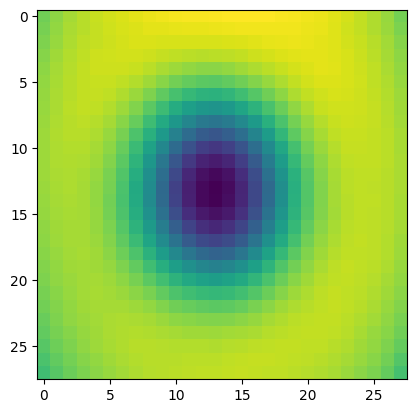

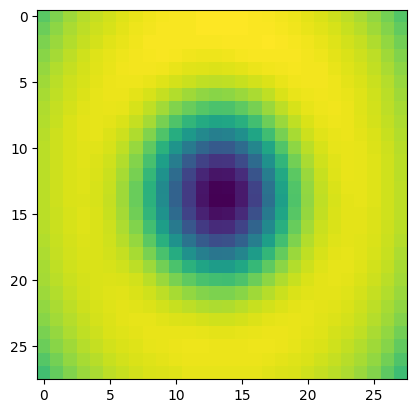

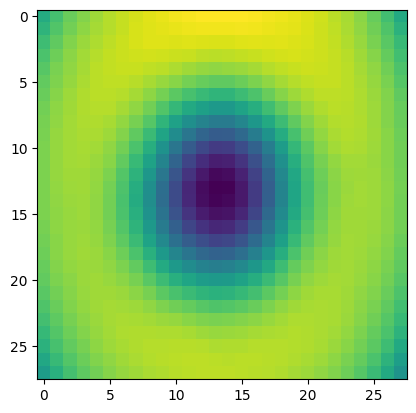

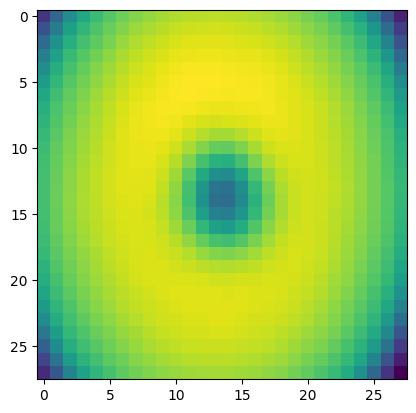

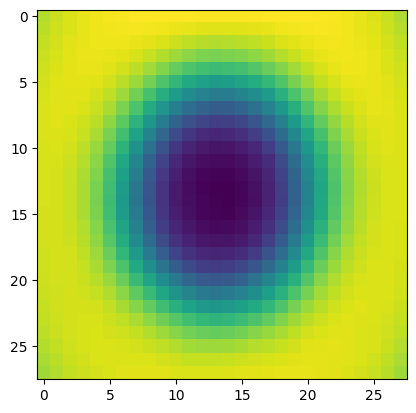

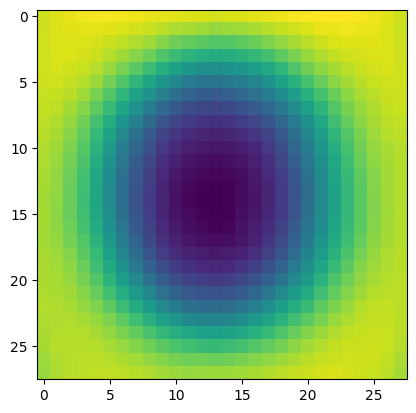

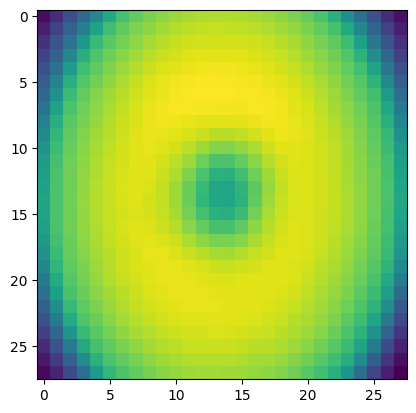

In [703]:
classes = num_cath # Number of diagnostical categories
max_iterations = 10000000


images = df_train.to_numpy()
# Remove the labels
images = images[:, 0:-1]  # arr: Shape: (#images, #pixels)

n = images.shape[0]
dim = images.shape[1]

# Initialize cluster centers by randomly picking points from the data
rndinds = np.random.permutation(n)
k_mus = images[rndinds[:classes]]


for iter in range(max_iterations):
    sqDmat = calcSqDistances(images, k_mus)
    rank = determineRnk(sqDmat)
    k_mus_old = k_mus
    k_mus = recalcMus(images, rank)

    if sum(abs(k_mus_old.flatten() - k_mus.flatten())) < 1e-6:
        break


for i in range(classes):
    disp_img(k_mus[i])

## Calculating the actual means of each cathegorys training data

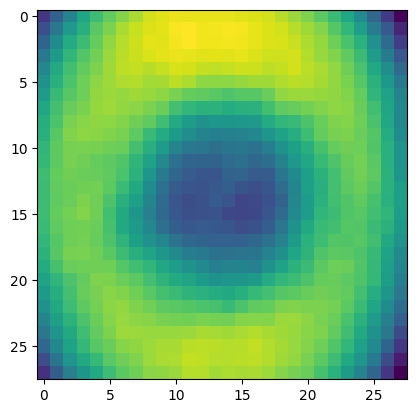

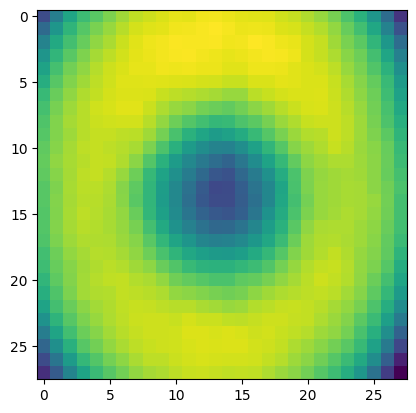

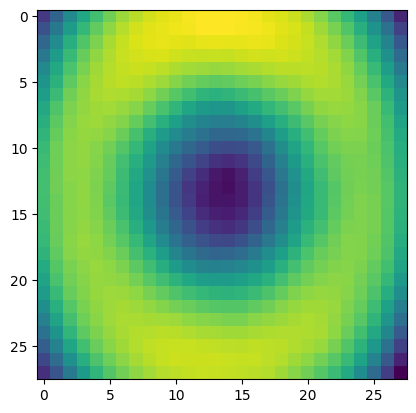

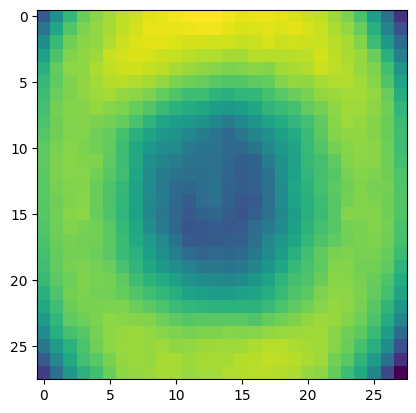

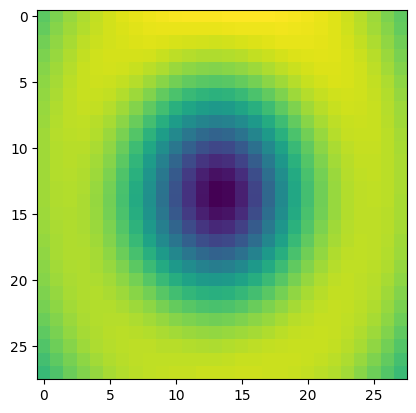

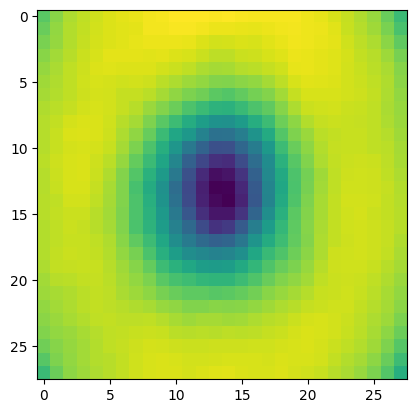

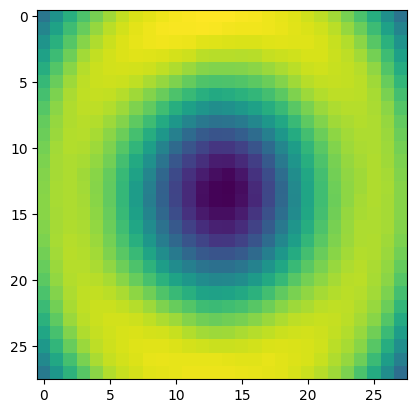

In [704]:
mean = []

for i in range(num_cath):
    mean.append(np.mean(df_train.loc[img_index_group_split[i][0]].iloc[:, :-1], axis=0))
    
    disp_img(mean[i])

## Matching the calculated clusters to the different diagnosis groups

Calculating the MSE for every calculated mean with every actual mean

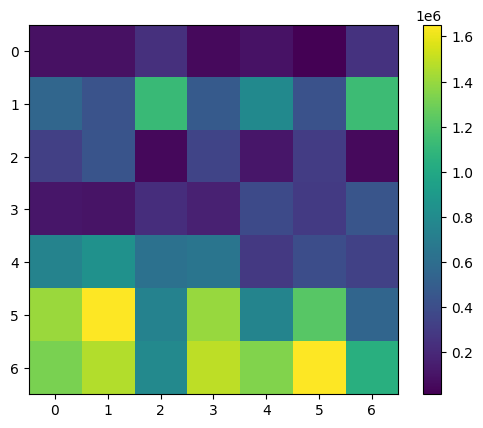

In [705]:
MSE = np.empty([len(mean), len(k_mus)])
for i in range(len(mean)):
    for j in range(len(k_mus)):
        MSE[j][i] = ((mean[i] - k_mus[j]).transpose().dot(mean[i] - k_mus[j]))

df_MSE = pd.DataFrame(MSE)

disp_img(df_MSE, colorbar=True)

### Function to Calculate the Mapping from the MSE Martix

Searches for a Mapping between the k_mus and the real means under to condition to minimize the total MSE of that mapping.

To achieve a bijective mapping a random k_mus is assigned to the mean with which it has the lowest MSE and then that mean is removed from the pool of possibilities for the other k-mus.

Then the next random k_mus is assigned to the mean with which is has the lowest MSE from the remaining pool of possibilities until all k_mus have their mapping.

To try to achieve a global MSE Minimum the function iterates iter times over this random selection process and picks the mapping with the lowest total cost.

Returns a vector $$x = [a, b, c, d, e, f, g]$$ with the mapping, meaning $$k_{mus}[i] \rightarrow mean[x[i]]$$

In [706]:
def find_mapping(df_MSE, iter=1000):     
    mappings = {}
    mappings['Map'] = []
    mappings['Cost'] = []
    for i in range(iter):
        mapping = []
        mean_list = list(range(len(mean)))
        mus_list = list(range(len(k_mus)))

        while len(mus_list) != 0:
            i = random.choice(mus_list)
            min_idx = df_MSE.iloc[i][mean_list].idxmin()
            mapping.append(min_idx)
            mean_list.remove(min_idx)
            mus_list.remove(i)

        cost = 0
        for i in range(len(mapping)):
            cost = cost + MSE[i][mapping[i]]

        mappings['Map'].append(mapping)
        mappings['Cost'].append(cost)

    min_index = mappings['Cost'].index(min(mappings['Cost']))
    return mappings['Map'][min_index]

Calling the find_mapping function and displaying the real mean and corresponding k_mus next to each other

[5, 1, 2, 3, 4, 6, 0]


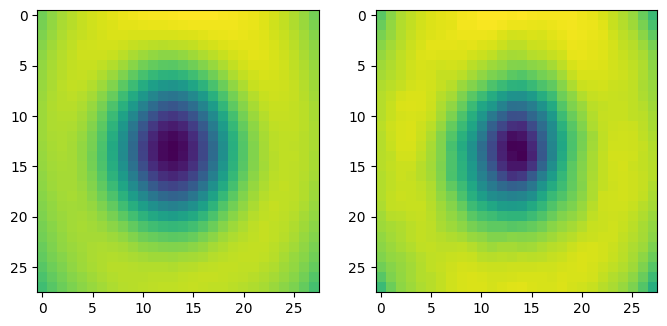

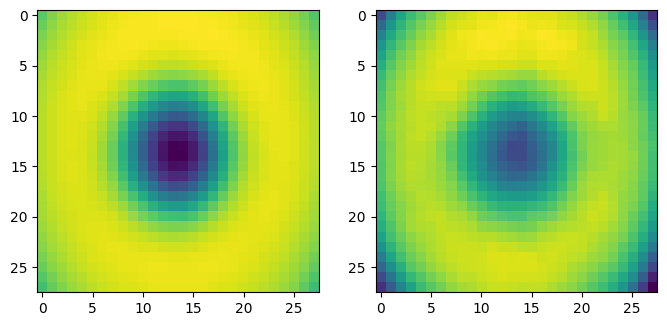

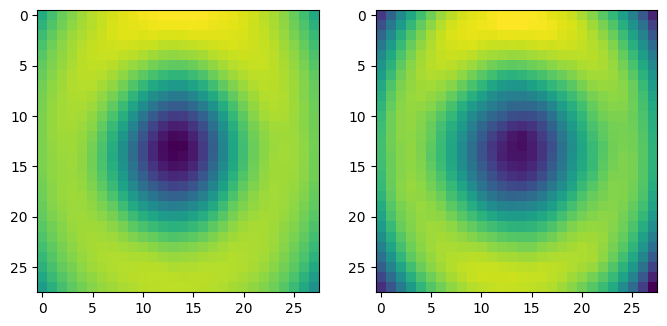

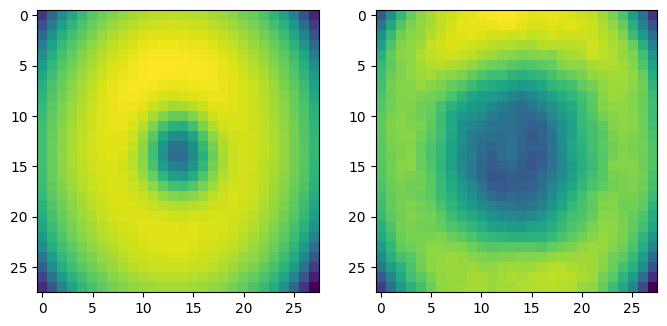

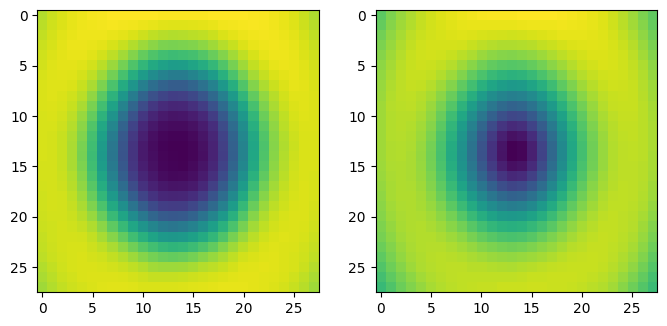

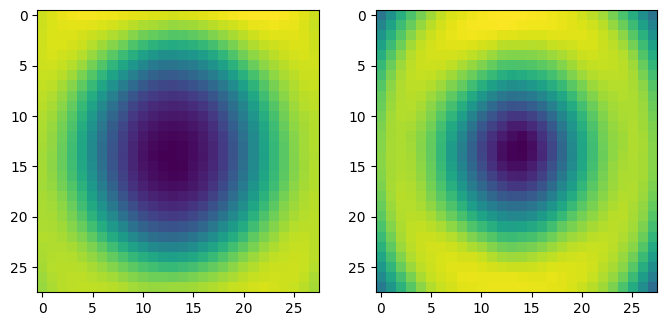

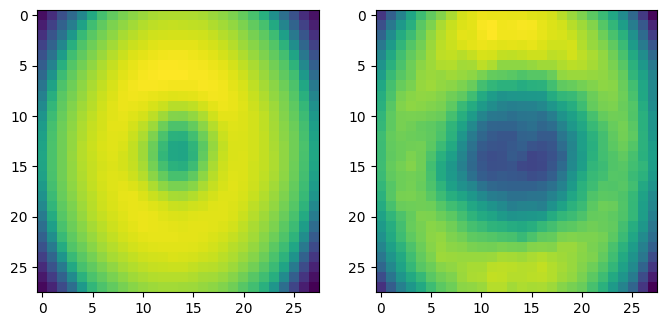

In [707]:
df_matching = find_mapping(df_MSE)
print(df_matching)

size = int(math.sqrt(len(k_mus[0])))
for i in range(num_cath):
    fig = plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(np.reshape(k_mus[i], (size, size)))
    plt.subplot(1, 2, 2)
    disp_img(mean[df_matching[i]])

## Feeding the training data and calculating the accuracy

In [708]:
def evaluate(): 
    right = 0
    wrong = 0

    for k in range(num_cath):
        for j in range(len(df.iloc[img_index_group_split[k][1]])):
            img = df.iloc[img_index_group_split[k][1]].iloc[j]
            img_label = img[-1]
            img_vec = img[0:-1]

            error = np.empty(num_cath)
            for i in range(num_cath):
                error[i] = (k_mus[i] - img_vec).transpose().dot(k_mus[i] - img_vec)

            idx_mu = error.argmin()
            guess = df_matching[idx_mu]
            
            if guess == img_label:
                right += 1
            else:
                wrong += 1

    accuracy = right/(right+wrong)

    return accuracy

print(evaluate())

0.16283716283716285
